In [98]:
import torch
import sys 
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sys.path.insert(0, os.path.abspath("/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering"))
from Code.utilities import cwt 

In [99]:
#Load Das sample and the transform of that sample 
transform = torch.load("../Data/synthetic-data/train-DAS/CWT-edDAS/transform0000_window1.pt")
sample = torch.load("../Data/synthetic-data/train-DAS/CWT-edDAS/samples0000.pt")
print(transform.shape)

torch.Size([512, 3000, 63])


In [100]:
#Perform k means on the features of the transform
features = np.array(transform)
features = np.reshape(features, (features.shape[0] * features.shape[1], -1))
print(features.shape)
n_cluters= 3
kmeans = KMeans(n_clusters= n_cluters)
kmeans.fit(features)

(1536000, 63)


KMeans(n_clusters=3)

In [101]:
#Reshape labels to be the shape of DAS Array 
labels = np.reshape(np.array(kmeans.labels_),(transform.shape[0], transform.shape[1]))
for i in range(n_cluters):
    print(f'{np.count_nonzero(labels == i)} appearances of label {i}')

15807 appearances of label 0
15760 appearances of label 1
1504433 appearances of label 2


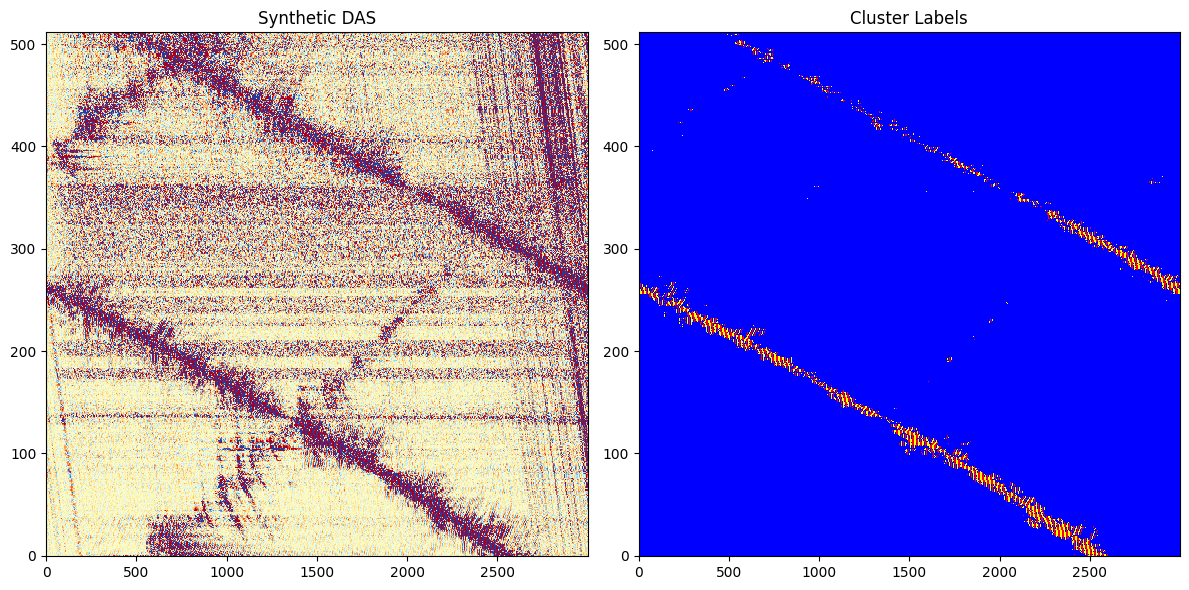

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,6))
ax1.imshow((sample / sample.std(dim=-1, keepdim=True)).detach().cpu().numpy(), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
ax2.imshow(labels, origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')
ax1.set_title("Synthetic DAS")
ax2.set_title("Cluster Labels")
plt.tight_layout()
plt.show()

In [103]:
centers = kmeans.cluster_centers_

print(centers.shape)
transform.shape

(3, 63)


torch.Size([512, 3000, 63])

In [104]:

def get_car_clusters(predictions, n_car_clusters, n_clusters):
    counts= np.zeros(n_clusters)
    for i in range(n_clusters):
        counts[i] = np.count_nonzero(predictions == i)
    car_clusters = np.zeros(n_car_clusters, dtype=np.int16)
    for i in range(n_car_clusters):
        car_clusters[i] = np.argmin(counts, axis=0)
        counts[car_clusters[i]] = np.inf
    return car_clusters

In [105]:
# Example of How inference should run
transform_flatt = np.reshape(transform.detach().numpy(), (transform.shape[0] *transform.shape[1], -1))
flatt_pred = kmeans.predict(transform_flatt)
car_clusters = get_car_clusters(flatt_pred, 2, 3)
print(car_clusters)
flatt_mask = np.isin(flatt_pred, car_clusters)
mask = np.reshape(flatt_mask, (transform.shape[0], transform.shape[1]))
muted_transform = transform.detach().clone()
muted_transform[mask, :]=  0.00001

[1 0]


In [106]:
#Example of applying mute to one Section of DAS data 
#Paramters for Inverse 
dj =.5
w0=8
n_samples = 1500
dt = .02
scales = cwt.get_scales(dt, dj,w0, n_samples)
big_scales = np.tile(scales, (n_samples, 1))
print(big_scales.shape)

def inverse_cwt(transform, scales, dj, dt, w0):
    #shape of transform should be scales, samples 
    if w0 != 8:
        print("err only w0 = 8 is implemented")
    scales_graph = torch.tensor(scales)
    inverse = transform / torch.sqrt(scales_graph.T) + 10e-10 
    inverse = torch.sum(inverse, dim=0).squeeze()

    colorado_factor = (dj * torch.sqrt(torch.tensor(dt, dtype=torch.float32))) / (0.7511 * 0.5758)
    inverse_w_factor = colorado_factor * inverse
    return inverse_w_factor.cpu().numpy()

inverse = np.zeros((muted_transform.shape[0], muted_transform.shape[1]))

for i in range(muted_transform.shape[0]):
    inverse[i,:n_samples] = inverse_cwt(muted_transform[i,:n_samples,:len(scales)].T, big_scales, dj, dt, w0)
    inverse[i,n_samples:] = inverse_cwt(muted_transform[i,n_samples:,:len(scales)].T, big_scales, dj, dt, w0)
        

(1500, 31)


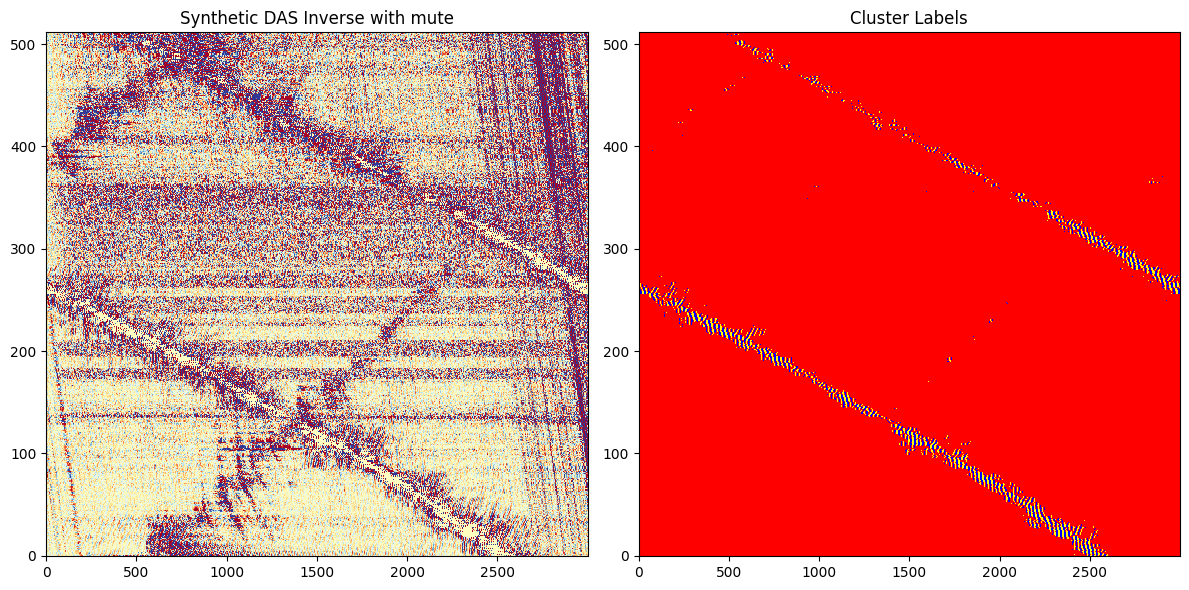

In [107]:
#Plot Muted DAS and Cluster Labels 
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,6))
ax1.imshow((inverse / inverse.std()), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
ax2.imshow(pred, origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')
ax1.set_title("Synthetic DAS Inverse with mute")
ax2.set_title("Cluster Labels")
plt.tight_layout()
plt.show()

In [108]:
#Do Kmeans with just the CWT across channels 
channels = transform[:,:,31:]
channel_features = np.reshape(channels, (channels.shape[0] * channels.shape[1], -1))
kmeans_channels = KMeans(n_clusters=n_cluters)
kmeans_channels.fit(channel_features)


KMeans(n_clusters=3)

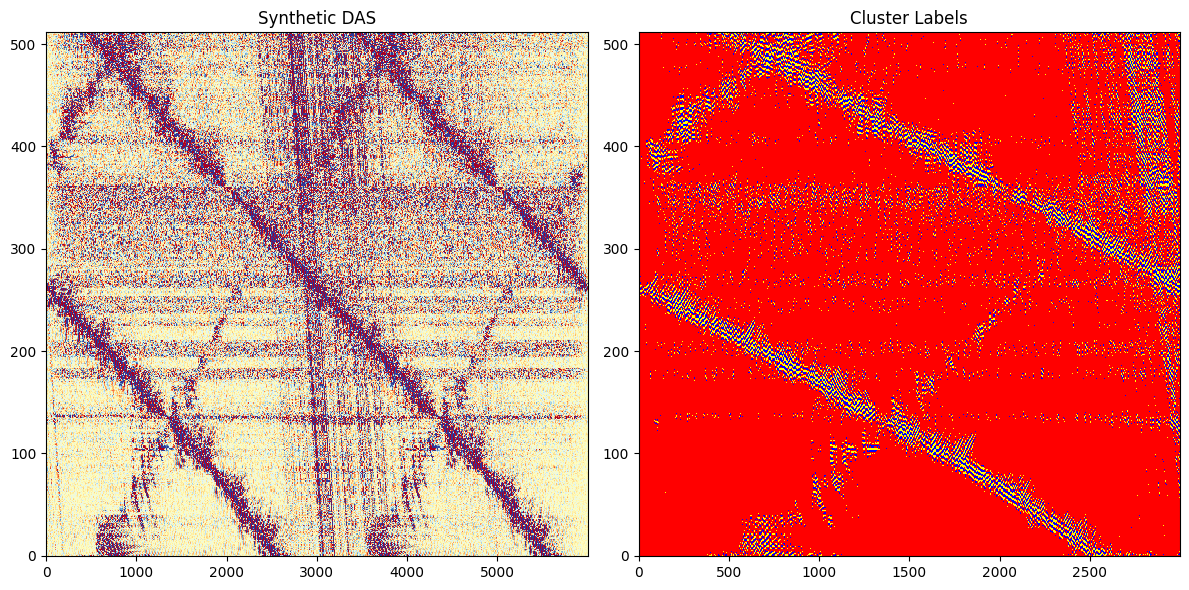

In [109]:
#Plot Kmeans with just clustering over channels
labels_channels = np.reshape(kmeans_channels.labels_, (channels.shape[0], channels.shape[1]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12,6))
ax1.imshow((sample / sample.std(dim=-1, keepdim=True)).detach().cpu().numpy(), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
ax2.imshow(labels_channels, origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')
ax1.set_title("Synthetic DAS")
ax2.set_title("Cluster Labels")
plt.tight_layout()
plt.show()

In [110]:
#Do kmeans with just the cwt across time 
time_scales = transform[:,:,:31]
time_features = np.reshape(time_scales, (time_scales.shape[0]* time_scales.shape[1],-1))
kmeans_time = KMeans(n_clusters=n_cluters)
kmeans_time.fit(time_features)

KMeans(n_clusters=3)

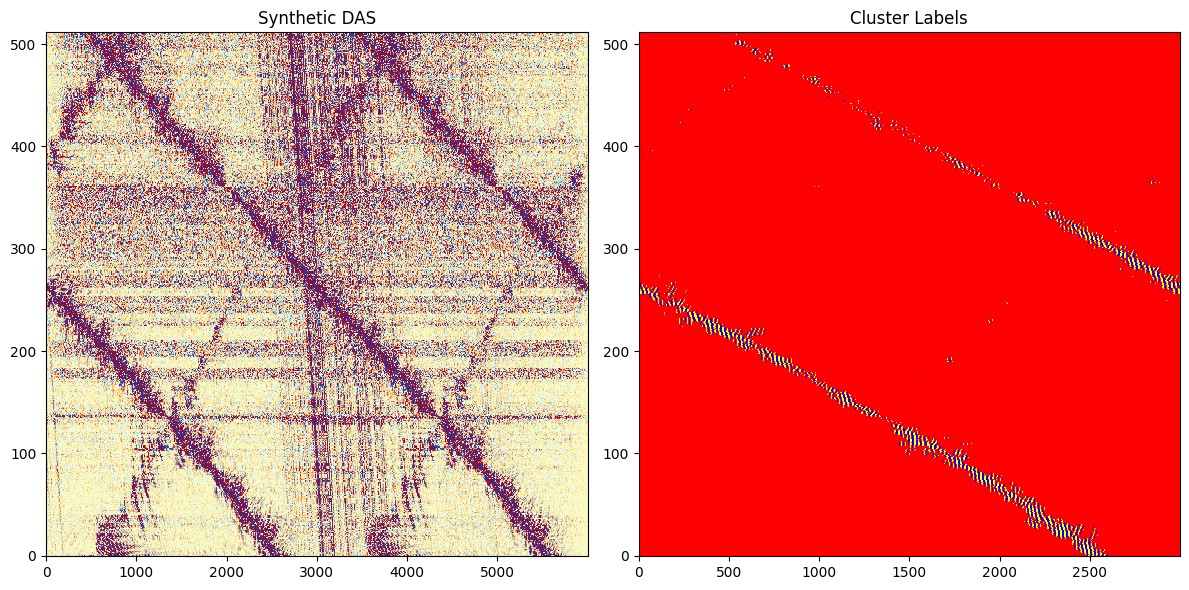

In [111]:
labels_time = np.reshape(kmeans_time.labels_, (time_scales.shape[0], time_scales.shape[1]))
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(12,6))
ax1.imshow((sample / sample.std(dim=-1, keepdim=True)).detach().cpu().numpy(), origin='lower', interpolation='nearest', cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
cmap = mcolors.ListedColormap(['yellow', 'green', 'red', 'blue'])
ax2.imshow(labels_time, origin='lower', interpolation='nearest', cmap=cmap, aspect='auto')
ax1.set_title("Synthetic DAS")
ax2.set_title("Cluster Labels")
plt.tight_layout()
plt.show()

In [112]:
#tried DBscan but runtime took way to long 
scan_labels = dbscan.labels_


NameError: name 'dbscan' is not defined